In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
import numpy as np
import os

import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [ ]:
!pip install pycocotools

from pycocotools.coco import COCO
from pycocotools.mask import *

In [ ]:

#SSD300 with Resnet50 backbone
import torchvision
import torch.nn as nn
from torchvision.models.detection.ssd import (
    SSD,
    DefaultBoxGenerator,
    SSDHead
)
def create_model(num_classes=91, size=300, nms=0.45):
    model_backbone = torchvision.models.resnet34( #updated from resnet34 to resnet50 backbone
        weights=torchvision.models.ResNet34_Weights.DEFAULT
    )
    conv1 = model_backbone.conv1
    bn1 = model_backbone.bn1
    relu = model_backbone.relu
    max_pool = model_backbone.maxpool
    layer1 = model_backbone.layer1
    layer2 = model_backbone.layer2
    layer3 = model_backbone.layer3
    layer4 = model_backbone.layer4
    backbone = nn.Sequential(
        conv1, bn1, relu, max_pool,
        layer1, layer2, layer3, layer4
    )

    out_channels = [512, 512, 512, 512, 512, 512]
    anchor_generator = DefaultBoxGenerator(
        [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
    )
    num_anchors = anchor_generator.num_anchors_per_location()
    head = SSDHead(out_channels, num_anchors, num_classes)
    model = SSD(
        backbone=backbone,
        num_classes=num_classes,
        anchor_generator=anchor_generator,
        size=(size, size),
        head=head,
        nms_thresh=nms
    )
    model.transform.min_size = (size, )
    model.transform.max_size = size
    return model

model = create_model(num_classes=4, size=600) #customizing the number of classes 3 + 1 (background)
print(model)


'''
#SSD300 with VGG16 backbone

import torchvision

from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights

def create_model(num_classes=91, size=300):
  model = torchvision.models.detection.ssd300_vgg16(
      weights=SSD300_VGG16_Weights.COCO_V1,
      pretrained=True
  )

  in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))

  num_anchors = model.anchor_generator.num_anchors_per_location()

  model.head.classification_head = SSDClassificationHead(
      in_channels=in_channels,
      num_anchors=num_anchors,
      num_classes=num_classes,
  )

  model.transform.min_size = (size, )
  model.transform.max_size = size
  return model

model = create_model(num_classes=3, size=640)
print(model)
'''

SSD(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

'\n#SSD300 with VGG16 backbone\n\nimport torchvision\n\nfrom torchvision.models.detection.ssd import SSDClassificationHead\nfrom torchvision.models.detection import _utils\nfrom torchvision.models.detection import SSD300_VGG16_Weights\n\ndef create_model(num_classes=91, size=300):\n  model = torchvision.models.detection.ssd300_vgg16(\n      weights=SSD300_VGG16_Weights.COCO_V1,\n      pretrained=True\n  )\n\n  in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))\n\n  num_anchors = model.anchor_generator.num_anchors_per_location()\n\n  model.head.classification_head = SSDClassificationHead(\n      in_channels=in_channels,\n      num_anchors=num_anchors,\n      num_classes=num_classes,\n  )\n\n  model.transform.min_size = (size, )\n  model.transform.max_size = size\n  return model\n\nmodel = create_model(num_classes=3, size=640)\nprint(model)\n'

In [ ]:
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, ToTensor, Normalize

def get_transforms():
    return Compose([
        Resize((600,600)),
        RandomHorizontalFlip(p=0.3),
        RandomVerticalFlip(p=0.3),
        ColorJitter(brightness=0.1, contrast=0.1),
        ToTensor(),
        #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [ ]:
class StrawberryDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
        self.transforms = get_transforms()  # Use torchvision transforms

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = Image.open(os.path.join(self.root, self.split, path)).convert("RGB")
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(target)

        # Original image size
        original_size = torch.tensor([image.width, image.height, image.width, image.height]).unsqueeze(0)

        # Process bboxes: COCO format (x_min, y_min, width, height) -> Convert to PyTorch format (x_min, y_min, x_max, y_max)
        boxes = [t['bbox'] for t in target]
        boxes = torch.tensor([[x, y, x + w, y + h] for x, y, w, h in boxes], dtype=torch.float32)

        # Rescale the bboxes in accordance with the image resizing
        new_size = torch.tensor([600, 600, 600, 600]).unsqueeze(0)
        boxes = boxes / original_size * new_size

        # Apply transforms to the image only
        if self.transforms is not None:
            image = self.transforms(image)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([index])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t.get('iscrowd', 0) for t in target], dtype=torch.int64)

        return image, targ


    def get_image_path(self, index):
        id = self.ids[index]
        path = self.coco.loadImgs(id)[0]['file_name']
        return os.path.join(self.root, self.split, path)

    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path='/content/gdrive/MyDrive/Colab Notebooks/UAVData/10m-images.v14i.coco'
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats #extraction of categories from the coco dataset
#n_classes = len(categories.keys()) #old method
n_classes = len(categories.keys()) + 1  # Adding 1 for the background

#categories

loading annotations into memory...
Done (t=0.96s)
creating index...
index created!


In [ ]:
#classes = [i[1]['name'] for i in categories.items()] #produces classes ['weeds', 'strawberry', 'weed']
#classes = ['__background__', 'weeds', 'strawberry', 'weed'] #SSD has the 0 slot reserved for the background
classes = ['__background__'] + [cat['name'] for cat_id, cat in sorted(categories.items())]

classes

['__background__', 'weeds', 'strawberry', 'weed']

In [ ]:
train_dataset = StrawberryDetection(root=dataset_path, split="train", transforms=get_transforms())
test_dataset = StrawberryDetection(root=dataset_path, split="valid", transforms=get_transforms())

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
loading annotations into memory...
Done (t=0.85s)
creating index...
index created!


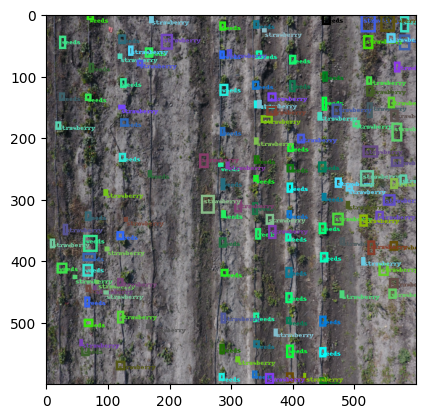

In [ ]:
sample = train_dataset[3]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
	img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
def collate_fn(batch):
	return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, collate_fn=collate_fn)

In [ ]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [ ]:
model = model.to(device)

In [ ]:


from torch.optim.lr_scheduler import CosineAnnealingLR
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)



'''
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
'''

'\noptimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)\nscheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)\n'

In [ ]:
import sys
from tqdm import tqdm

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        #optimizer.step() #test to see if this makes the training loop perform better, taken from my previous custom made CNN
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        #print(loss_dict.keys())
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Convert list of dictionaries to a pandas DataFrame
    all_losses_dict = pd.DataFrame(all_losses_dict)

    # Calculate mean losses
    loss_bbox_reg_mean = all_losses_dict['bbox_regression'].mean() if 'bbox_regression' in all_losses_dict else 0
    loss_classification_mean = all_losses_dict['classification'].mean() if 'classification' in all_losses_dict else 0

    # Print summary
    print(f"Epoch {epoch}, lr: {optimizer.param_groups[0]['lr']:.6f}, "
          f"loss: {np.mean(all_losses):.6f}, "
          f"loss_bbox_reg: {loss_bbox_reg_mean:.6f}, "
          f"loss_classification: {loss_classification_mean:.6f}")

    scheduler.step()

    return all_losses_dict


In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
	train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


Epoch 0, lr: 0.001000, loss: 20.697189, loss_bbox_reg: 11.368169, loss_classification: 9.329019


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 1, lr: 0.000976, loss: 12.221979, loss_bbox_reg: 7.327029, loss_classification: 4.894950


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Epoch 2, lr: 0.000905, loss: 10.406836, loss_bbox_reg: 6.534328, loss_classification: 3.872507


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 3, lr: 0.000796, loss: 9.940281, loss_bbox_reg: 6.542390, loss_classification: 3.397892


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Epoch 4, lr: 0.000658, loss: 9.811668, loss_bbox_reg: 6.560434, loss_classification: 3.251234


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 5, lr: 0.000505, loss: 9.500338, loss_bbox_reg: 6.380715, loss_classification: 3.119623


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch 6, lr: 0.000352, loss: 9.364937, loss_bbox_reg: 6.295549, loss_classification: 3.069387


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Epoch 7, lr: 0.000214, loss: 8.968672, loss_bbox_reg: 5.949481, loss_classification: 3.019190


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 8, lr: 0.000105, loss: 8.853371, loss_bbox_reg: 5.826838, loss_classification: 3.026533


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch 9, lr: 0.000034, loss: 8.888149, loss_bbox_reg: 5.879415, loss_classification: 3.008734


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch 10, lr: 0.000010, loss: 8.937968, loss_bbox_reg: 5.944142, loss_classification: 2.993827


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch 11, lr: 0.000034, loss: 8.751979, loss_bbox_reg: 5.767704, loss_classification: 2.984276


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Epoch 12, lr: 0.000105, loss: 8.531349, loss_bbox_reg: 5.552898, loss_classification: 2.978452


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch 13, lr: 0.000214, loss: 8.591363, loss_bbox_reg: 5.610633, loss_classification: 2.980730


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Epoch 14, lr: 0.000352, loss: 8.916740, loss_bbox_reg: 5.906477, loss_classification: 3.010262


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Epoch 15, lr: 0.000505, loss: 8.325620, loss_bbox_reg: 5.293617, loss_classification: 3.032004


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Epoch 16, lr: 0.000658, loss: 8.578780, loss_bbox_reg: 5.559194, loss_classification: 3.019586


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch 17, lr: 0.000796, loss: 9.049670, loss_bbox_reg: 5.993474, loss_classification: 3.056196


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch 18, lr: 0.000905, loss: 8.782559, loss_bbox_reg: 5.734144, loss_classification: 3.048414


100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


Epoch 19, lr: 0.000976, loss: 8.928065, loss_bbox_reg: 5.858015, loss_classification: 3.070051


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Epoch 20, lr: 0.001000, loss: 8.809590, loss_bbox_reg: 5.728281, loss_classification: 3.081309


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Epoch 21, lr: 0.000976, loss: 9.156351, loss_bbox_reg: 6.072367, loss_classification: 3.083984


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch 22, lr: 0.000905, loss: 9.099019, loss_bbox_reg: 6.033007, loss_classification: 3.066012


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch 23, lr: 0.000796, loss: 8.661772, loss_bbox_reg: 5.581602, loss_classification: 3.080170


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch 24, lr: 0.000658, loss: 8.723912, loss_bbox_reg: 5.698463, loss_classification: 3.025449


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch 25, lr: 0.000505, loss: 10.503405, loss_bbox_reg: 7.258935, loss_classification: 3.244470


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 26, lr: 0.000352, loss: 9.138054, loss_bbox_reg: 6.026678, loss_classification: 3.111375


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Epoch 27, lr: 0.000214, loss: 8.395774, loss_bbox_reg: 5.375378, loss_classification: 3.020397


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 28, lr: 0.000105, loss: 8.318004, loss_bbox_reg: 5.339041, loss_classification: 2.978963


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Epoch 29, lr: 0.000034, loss: 8.277775, loss_bbox_reg: 5.321399, loss_classification: 2.956376


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 30, lr: 0.000010, loss: 8.092129, loss_bbox_reg: 5.160124, loss_classification: 2.932006


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Epoch 31, lr: 0.000034, loss: 8.296858, loss_bbox_reg: 5.337072, loss_classification: 2.959786


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 32, lr: 0.000105, loss: 8.054258, loss_bbox_reg: 5.116282, loss_classification: 2.937975


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 33, lr: 0.000214, loss: 8.050585, loss_bbox_reg: 5.121989, loss_classification: 2.928596


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Epoch 34, lr: 0.000352, loss: 8.227375, loss_bbox_reg: 5.297377, loss_classification: 2.929999


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Epoch 35, lr: 0.000505, loss: 8.325656, loss_bbox_reg: 5.351490, loss_classification: 2.974166


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Epoch 36, lr: 0.000658, loss: 8.416496, loss_bbox_reg: 5.440243, loss_classification: 2.976253


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Epoch 37, lr: 0.000796, loss: 8.782913, loss_bbox_reg: 5.702433, loss_classification: 3.080480


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch 38, lr: 0.000905, loss: 8.458838, loss_bbox_reg: 5.391201, loss_classification: 3.067637


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Epoch 39, lr: 0.000976, loss: 8.457141, loss_bbox_reg: 5.405968, loss_classification: 3.051173


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Epoch 40, lr: 0.001000, loss: 8.516049, loss_bbox_reg: 5.449908, loss_classification: 3.066141


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Epoch 41, lr: 0.000976, loss: 8.306292, loss_bbox_reg: 5.314149, loss_classification: 2.992144


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 42, lr: 0.000905, loss: 8.317850, loss_bbox_reg: 5.323580, loss_classification: 2.994270


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 43, lr: 0.000796, loss: 7.996596, loss_bbox_reg: 5.054512, loss_classification: 2.942084


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Epoch 44, lr: 0.000658, loss: 7.984507, loss_bbox_reg: 5.035064, loss_classification: 2.949443


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch 45, lr: 0.000505, loss: 7.878424, loss_bbox_reg: 4.978412, loss_classification: 2.900012


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch 46, lr: 0.000352, loss: 7.828130, loss_bbox_reg: 4.968595, loss_classification: 2.859536


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch 47, lr: 0.000214, loss: 7.818031, loss_bbox_reg: 4.936447, loss_classification: 2.881584


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Epoch 48, lr: 0.000105, loss: 7.842297, loss_bbox_reg: 4.987604, loss_classification: 2.854693


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

Epoch 49, lr: 0.000034, loss: 7.933748, loss_bbox_reg: 5.070469, loss_classification: 2.863278


In [ ]:
import matplotlib.patches as patches

#classes = ['background', 'weed', 'strawberry']

color_map = {class_name: plt.get_cmap("tab20")(i) for i, class_name in enumerate(classes)}

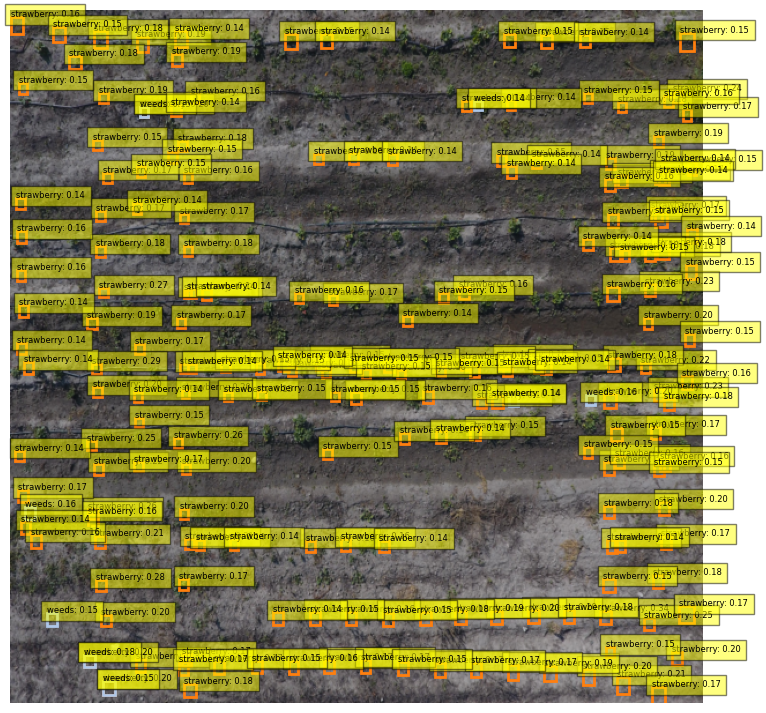

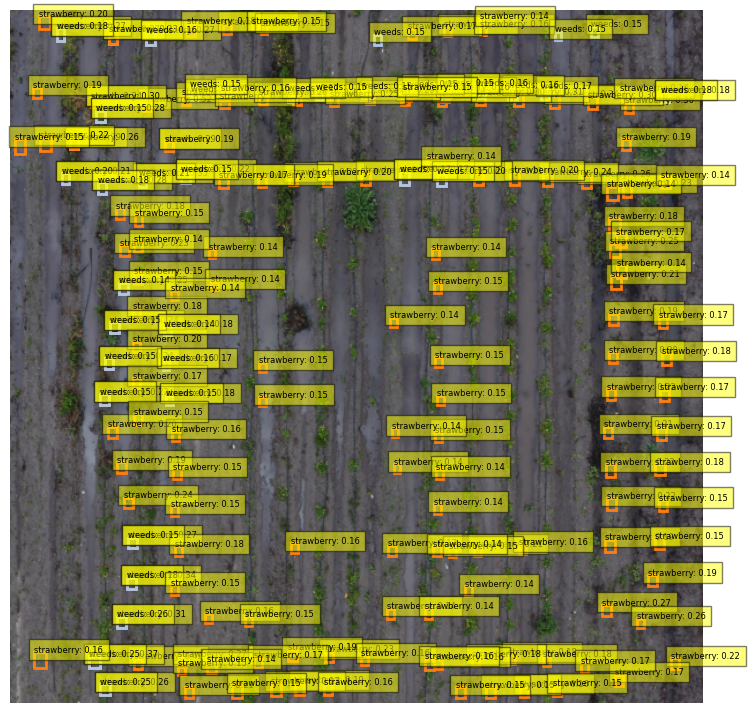

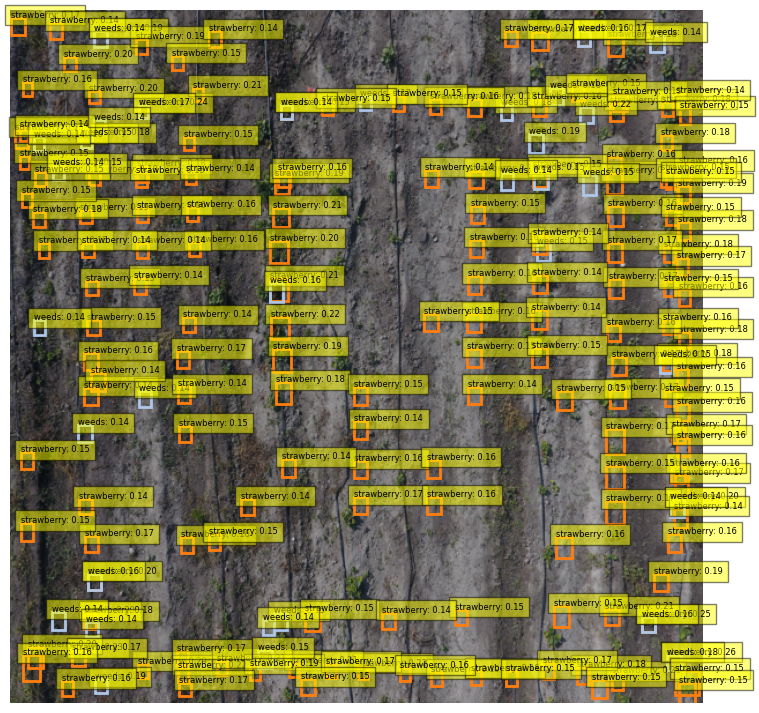

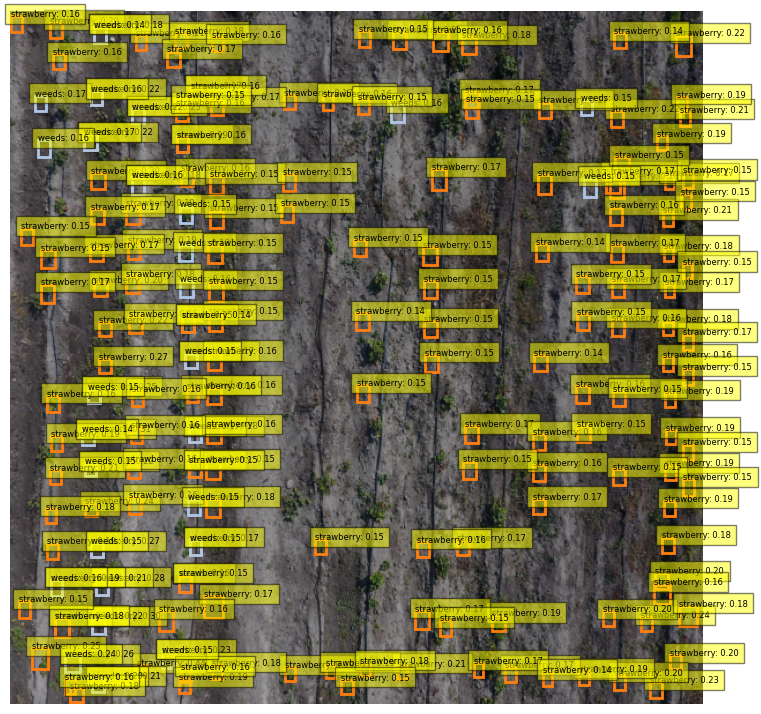

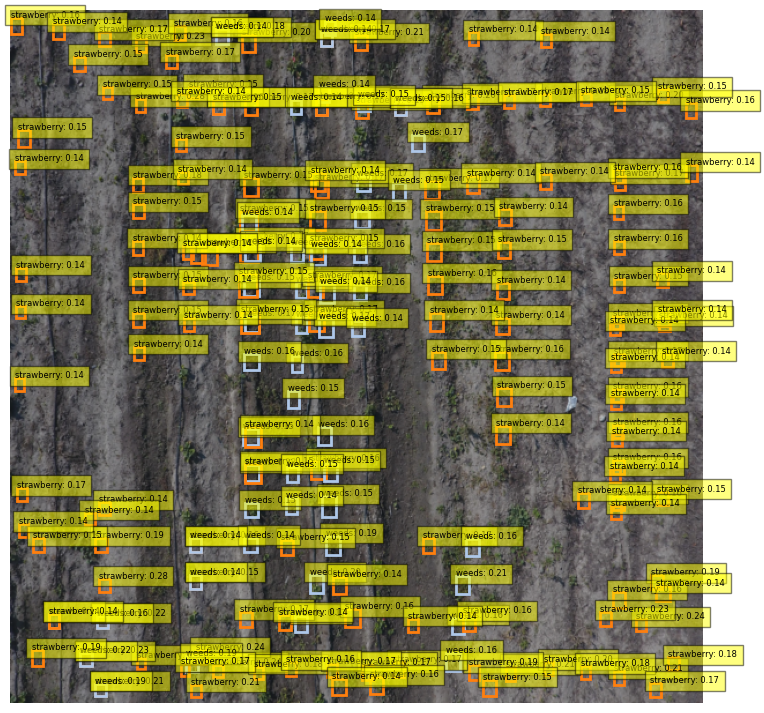

"\nmean = torch.tensor([0.485, 0.456, 0.406]).to(device)\nstd = torch.tensor([0.229, 0.224, 0.225]).to(device)\n\n# Get a test image and prediction\nimg, _ = test_dataset[0]  # Normalized image\nimg = img.to(device)\n\n# Set the model to evaluation mode\nmodel.eval()\n\n# Make predictions\nwith torch.no_grad():\n    prediction = model([img])\n    pred = prediction[0]\n\n# Reverse the normalization on a clone of img to display it\nimg_for_display = img.clone()\nfor channel in range(img_for_display.shape[0]):\n    img_for_display[channel] = img_for_display[channel] * std[channel] + mean[channel]\n\n# Clamp the values to the [0, 1] range and convert it to a NumPy array for display\nimg_for_display = torch.clamp(img_for_display, 0, 1)\nimg_for_display = img_for_display.cpu().detach().numpy()\n\n# Draw the predictions on the image\nfig, ax = plt.subplots(1, figsize=(12, 9))\nax.imshow(np.transpose(img_for_display, (1, 2, 0)))  # Reorder the dimensions to HxWxC format\n\n\n# Lower the confid

In [ ]:
'''
# Get a test image
img, _ = test_dataset[0] #first image
img = img.to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    prediction = model([img])
    pred = prediction[0]

# Convert the image tensor to the same format as used for visualization in cell 11
img_for_display = img.cpu().detach().numpy()
if img_for_display.max() <= 1.0:
    # tensor is normalized between 0 and 1, rescale it to 0-255.
    img_for_display = (img_for_display * 255).astype(np.uint8)

# Draw the predictions on the image
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img_for_display.transpose(1, 2, 0))  # Transpose to convert to HxWxC format

# Lower the confidence threshold to check for any detections (Anything above .1 causes model to not make predictions)
confidence_threshold = 0.1

# Filter out the predictions based on the confidence
scores = pred['scores'].cpu().numpy()
pred_boxes = pred['boxes'].cpu().numpy()[scores > confidence_threshold]
pred_labels = pred['labels'].cpu().numpy()[scores > confidence_threshold]
scores = scores[scores > confidence_threshold]

# Draw the bounding boxes and labels on the image
for box, label, score in zip(pred_boxes, pred_labels, scores):
    label_name = classes[label]
    color = color_map[label_name]
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2,
                             edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], f'{label_name}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5),
            fontsize=6, color='black')

# Show the final figure with bounding boxes
ax.axis('off')
plt.show()
'''


# Set the model to evaluation mode
model.eval()

# Loop over the test dataset
for i in range(len(test_dataset)):
    # Get a test image
    img, _ = test_dataset[i]
    img = img.to(device)

    # Make predictions
    with torch.no_grad():
        prediction = model([img])
        pred = prediction[0]

    # Convert the image tensor to the same format as used for visualization
    img_for_display = img.cpu().detach().numpy()
    if img_for_display.max() <= 1.0:
        # tensor is normalized between 0 and 1, rescale it to 0-255.
        img_for_display = (img_for_display * 255).astype(np.uint8)

    # Create a subplot for each image
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_for_display.transpose(1, 2, 0))  # Transpose to convert to HxWxC format

    # Lower the confidence threshold to check for any detections
    confidence_threshold = 0.1

    # Filter out the predictions based on the confidence
    scores = pred['scores'].cpu().numpy()
    pred_boxes = pred['boxes'].cpu().numpy()[scores > confidence_threshold]
    pred_labels = pred['labels'].cpu().numpy()[scores > confidence_threshold]
    scores = scores[scores > confidence_threshold]

    # Draw the bounding boxes and labels on the image
    for box, label, score in zip(pred_boxes, pred_labels, scores):
        label_name = classes[label]
        color = color_map[label_name]
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2,
                                 edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f'{label_name}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5),
                fontsize=6, color='black')

    # Show the final figure with bounding boxes
    ax.axis('off')
    plt.show()

    #break



'''
mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Get a test image and prediction
img, _ = test_dataset[0]  # Normalized image
img = img.to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    prediction = model([img])
    pred = prediction[0]

# Reverse the normalization on a clone of img to display it
img_for_display = img.clone()
for channel in range(img_for_display.shape[0]):
    img_for_display[channel] = img_for_display[channel] * std[channel] + mean[channel]

# Clamp the values to the [0, 1] range and convert it to a NumPy array for display
img_for_display = torch.clamp(img_for_display, 0, 1)
img_for_display = img_for_display.cpu().detach().numpy()

# Draw the predictions on the image
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np.transpose(img_for_display, (1, 2, 0)))  # Reorder the dimensions to HxWxC format


# Lower the confidence threshold to check for any detections (Anything above .1 causes model to not make predictions)
confidence_threshold = 0.1

# Filter out the predictions based on the confidence
scores = pred['scores'].cpu().numpy()
pred_boxes = pred['boxes'].cpu().numpy()[scores > confidence_threshold]
pred_labels = pred['labels'].cpu().numpy()[scores > confidence_threshold]
scores = scores[scores > confidence_threshold]

# Draw the bounding boxes and labels on the image
for box, label, score in zip(pred_boxes, pred_labels, scores):
    label_name = classes[label]
    color = color_map[label_name]
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2,
                             edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], f'{label_name}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5),
            fontsize=6, color='black')

# Show the final figure with bounding boxes
ax.axis('off')
plt.show()
'''